In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import zipfile
import os

# Load Data from google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_src/RAVDESS.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/RAVDESS')

Mounted at /content/drive


# Analysis

Sample rate : 48000
Original audio :


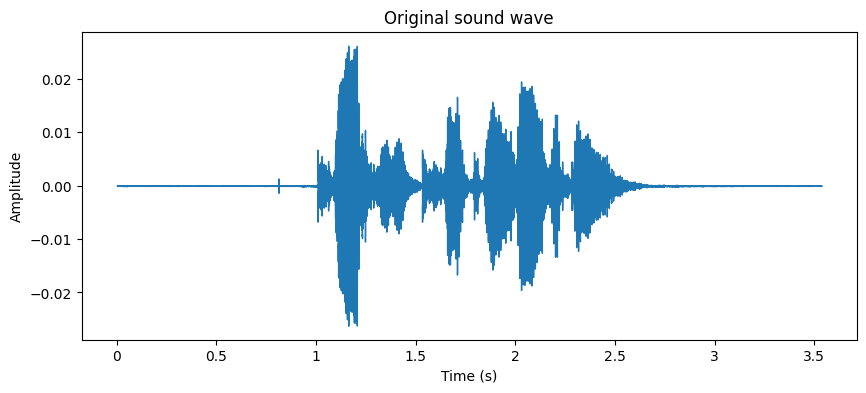

Audio after padding :


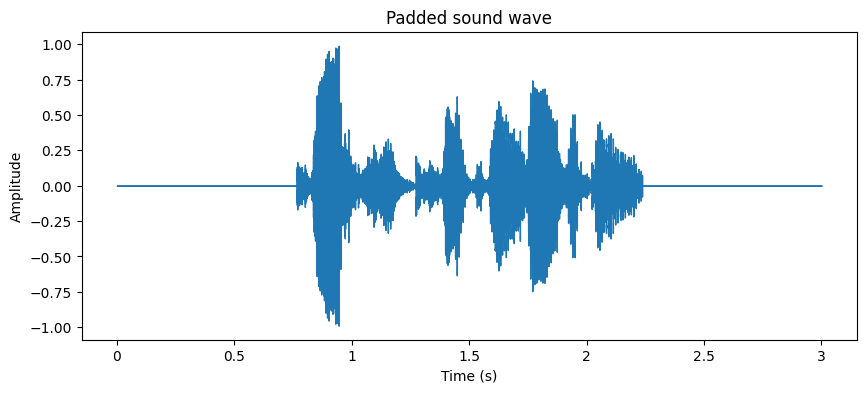

In [6]:
file_path = "/content/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav"
y, sr = librosa.load(file_path, sr=None)  # Load with native sample rate

print("Sample rate : " + str(sr))

# Play original audio
print("Original audio :")
display(Audio(y, rate=sr))

# Show original sound wave
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Original sound wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Normalization based on maximum amplitude
y_normalized = y / np.max(np.abs(y))

# Remove silence from the beginning and end
y_trimmed, index = librosa.effects.trim(y_normalized, top_db=20)

# Resampling at 16000 Hz
target_sr = 16000
y_resampled = librosa.resample(y_trimmed, orig_sr=sr, target_sr=target_sr)

# Calculate target length (3 seconds)
target_length = target_sr * 3  # 3 seconds

# Calculate how much padding is needed at the start and end
current_length = len(y_resampled)
padding_length = target_length - current_length

if padding_length > 0:
    # Split padding equally between start and end
    pad_start = padding_length // 2
    pad_end = padding_length - pad_start

    # Add padding at the start and end
    y_padded = np.pad(y_resampled, (pad_start, pad_end), mode='constant')
else:
    # If audio is longer than 3 seconds, crop it
    y_padded = y_resampled[:target_length]

# Play audio after padding
print("Audio after padding :")
display(Audio(y_padded, rate=target_sr))

# Show padded sound wave
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_padded, sr=target_sr)
plt.title("Padded sound wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

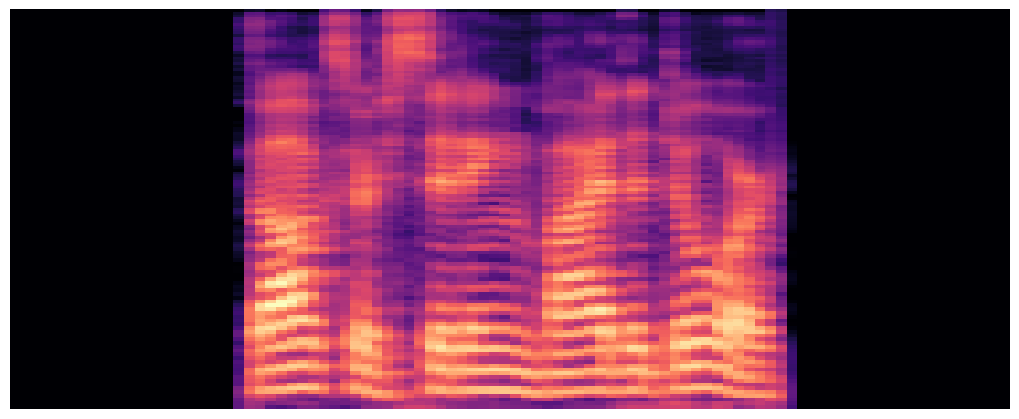

In [8]:
def preprocess_audio(file_path, target_duration=3, target_sr=16000):
    """
    Charge un fichier audio, enlève les silences, le rééchantillonne,
    et ajoute du padding pour que la durée soit égale à target_duration (en secondes).

    Args:
    - file_path (str): Le chemin du fichier audio.
    - target_duration (float): La durée cible de l'audio en secondes.
    - target_sr (int): Le taux d'échantillonnage cible pour l'audio.

    Returns:
    - y_padded (numpy.ndarray): L'audio traité avec padding ajouté si nécessaire.
    """
    # Charger l'audio
    y, sr = librosa.load(file_path, sr=None)  # Charger avec le taux d'échantillonnage natif

    # Normalisation basée sur l'amplitude maximale
    y_normalized = y / np.max(np.abs(y))

    # Suppression des silences au début et à la fin
    y_trimmed, index = librosa.effects.trim(y_normalized, top_db=20)

    # Rééchantillonnage à target_sr
    y_resampled = librosa.resample(y_trimmed, orig_sr=sr, target_sr=target_sr)

    # Calcul de la durée cible en nombre d'échantillons
    target_length = target_sr * target_duration  # Durée cible en nombre d'échantillons
    current_length = len(y_resampled)
    padding_length = target_length - current_length

    if padding_length > 0:
        # Répartition du padding entre le début et la fin
        pad_start = padding_length // 2
        pad_end = padding_length - pad_start

        # Ajouter du padding au début et à la fin
        y_padded = np.pad(y_resampled, (pad_start, pad_end), mode='constant')
    else:
        # Si l'audio est plus long que la durée cible, on le coupe
        y_padded = y_resampled[:target_length]

    return y_padded, target_sr

target_duration = 3
target_sr = 16000

file_path = "/content/RAVDESS/Actor_07/03-01-02-01-02-02-07.wav"
y_padded, sr = preprocess_audio(file_path, target_duration=target_duration, target_sr=target_sr)

# Obtenir un spectrogramme Mel
S = librosa.feature.melspectrogram(y=y_padded, sr=sr, n_mels=128, fmax=8000)

# Convertir le spectrogramme Mel en échelle logarithmique
S_db = librosa.power_to_db(S, ref=np.max)

# Afficher le spectrogramme sans axes et échelle
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)

# Enlever les axes et la colorbar
plt.axis('off')  # Supprimer les axes
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Enlever les marges

# Sauvegarder le spectrogramme en tant que PNG
plt.savefig('spectrogramme.png', bbox_inches='tight', pad_inches=0)

# Afficher le spectrogramme
plt.show()


In [9]:
def generate_spectrogram(y, sr, output_file):
    """
    Génère un spectrogramme Mel sans bords noirs ni compression
    et l'enregistre en PNG.
    """
    # Calculer le spectrogramme Mel
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Déterminer la taille optimale pour le spectrogramme
    plt.figure(figsize=(S_db.shape[1] / 100, S_db.shape[0] / 100), dpi=100)
    plt.axis('off')  # Supprimer les axes
    librosa.display.specshow(S_db, sr=sr, fmax=8000, x_axis=None, y_axis=None)

    # Sauvegarder le spectrogramme avec un cadre parfaitement ajusté
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Éliminer les marges
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=100, transparent=True)
    plt.close()


In [22]:
file_path = "/content/Actor_01/03-01-02-01-01-01-01.wav"  # Chemin du fichier audio
output_file = "/content/spectrogram_preprocessed.png"    # Chemin de sortie pour le PNG

# Étape 1 : Prétraiter l'audio
y_padded, sr = preprocess_audio(file_path)

# Étape 2 : Générer et sauvegarder le spectrogramme
generate_spectrogram(y_padded, sr, output_file)

print(f"Spectrogramme prétraité sauvegardé dans : {output_file}")

Spectrogramme prétraité sauvegardé dans : /content/spectrogram_preprocessed.png


In [15]:
# Dossier contenant les fichiers RAVDESS
input_dir = "/content/RAVDESS/"  # Modifier ce chemin pour le répertoire RAVDESS
output_dir = "/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations"  # Dossier où les spectrogrammes seront enregistrés

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dictionnaire pour gérer les indices spécifiques à chaque émotion
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

emotion_indices = {
    'neutral': 1,
    'calm': 1,
    'happy': 1,
    'sad': 1,
    'angry': 1,
    'fearful': 1,
    'disgust': 1,
    'surprised': 1
}

# Parcourir les fichiers dans le dossier RAVDESS
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.wav'):
            print(f"Traitement du fichier : {file}")
            # Obtenir le chemin du fichier audio
            file_path = os.path.join(root, file)

            # Extraire l'émotion à partir du nom du fichier
            emotion_code = file.split('-')[2]  # Exemple pour "03-01-02-01-01-01-01.wav", on prend le "03"
            emotion = emotion_map.get(emotion_code, 'unknown')

            # Prétraiter l'audio
            y_padded, sr = preprocess_audio(file_path)

            # Générer le nom du fichier de sortie pour le spectrogramme
            output_file = os.path.join(output_dir, f"RAVDESS_{emotion}_{emotion_indices[emotion]}.png")

            # Générer et sauvegarder le spectrogramme
            generate_spectrogram(y_padded, sr, output_file)

            print(f"Spectrogramme généré et sauvegardé : {output_file}")

            # Incrémenter l'indice pour cette émotion spécifique
            emotion_indices[emotion] += 1

Traitement du fichier : 03-01-04-02-01-02-21.wav
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations/RAVDESS_sad_1.png
Traitement du fichier : 03-01-02-02-02-02-21.wav
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations/RAVDESS_calm_1.png
Traitement du fichier : 03-01-04-01-02-02-21.wav
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations/RAVDESS_sad_2.png
Traitement du fichier : 03-01-08-01-01-02-21.wav
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations/RAVDESS_surprised_1.png
Traitement du fichier : 03-01-07-01-01-01-21.wav
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations/RAVDESS_disgust_1.png
Traitement du fichier : 03-01-02-02-01-01-21.wav
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speec

In [ ]:
dataset_path = '../dataset/'

audio_data = []
labels = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Is a direcotry
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):  # Is audio file .wav
                file_path = os.path.join(folder_path, file)

                # Load audio file
                y, sr = librosa.load(file_path, sr=None)  # sr=None to keep the original sample rate

                audio_data.append(y)
                labels.append(file.split('.')[0])

                print(f"Chargé {file} avec taux d'échantillonnage {sr}")

Chargé 03-01-01-01-01-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-01-01-01-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-01-01-02-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-01-01-02-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-01-01-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-01-01-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-01-02-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-01-02-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-02-01-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-02-01-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-02-02-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-02-02-02-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-03-01-01-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-03-01-01-02-01.wav avec taux d'échantillonnage 48000
Chargé 03-01-03-01-02-01-01.wav avec taux d'échantillonnage 48000
Chargé 03-

# Changing the way audio files are represented

In [ ]:
# Create a folder to save audio representations
spectrograms_dir = 'audio_representations/spectrograms'
os.makedirs(spectrograms_dir, exist_ok=True)

# Create a folder to save MFCCs images
MFCC_dir = 'audio_representations/MFCCs'
os.makedirs(MFCC_dir, exist_ok=True)

## Spectrograms

In [ ]:
def generate_spectrogram(y, sr, output_file):
    # Compute spectrogram with short-time Fourier transform (STFT)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Generate and save
    plt.figure(figsize=(2.56, 2.56))
    plt.axis('off')
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

In [ ]:
for (y, label) in zip(audio_data, labels):
    output_file = os.path.join(spectrograms_dir, f'{label}.png')
    generate_spectrogram(y, sr, output_file)
    print(f"Spectrogramme sauvegardé sous {output_file}")


Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-01-01-01-01-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-01-01-01-02-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-01-01-02-01-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-01-01-02-02-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-01-01-01-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-01-01-02-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-01-02-01-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-01-02-02-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-02-01-01-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-02-01-02-01.png
Spectrogramme sauvegardé sous audio_representations/spectrograms\03-01-02-02-02-01-01.png
Spectrogra

## MFCCs

In [ ]:
def generate_mfcc(y, sr, output_file, n_mfcc=13):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Generate and save
    plt.figure(figsize=(2.56, 2.56))
    plt.axis('off')
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

In [ ]:
for (y, label) in zip(audio_data, labels):
    output_file = os.path.join(MFCC_dir, f'{label}.png')
    generate_mfcc(y, sr, output_file)
    print(f"MFCCs sauvegardé sous {output_file}")

MFCCs sauvegardé sous audio_representations/MFCCs\03-01-01-01-01-01-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-01-01-01-02-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-01-01-02-01-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-01-01-02-02-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-01-01-01-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-01-01-02-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-01-02-01-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-01-02-02-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-02-01-01-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-02-01-02-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-02-02-01-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-02-02-02-02-01.png
MFCCs sauvegardé sous audio_representations/MFCCs\03-01-03-01-01-01-01.png
MFCCs sauvegardé sous aud